# Modified Kinetic Energy for 1D Sine Potential

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from module.hamilton_class import HamiltonSystem
from module.plot_class import Plotter
from module.sampling import metropolis_hastings, sample_initial_conditions


# General parameters for different kinds of dynamics
k = 2.0
m = 1.0 # mass
suppression_factor = 50 # to suppress the effect of x^2 term
t_max = 30.0 # maximum time

potential = lambda x: k * (x**2) / suppression_factor - k * np.cos(x)

### Derivatives

In [2]:
# Hamiltonian 1
# H = p^2 / 2m + kx^2 / suppression_factor - k * cos(x)
# x dot = dH / dp
# p dot = - dH / dx

def H1_x_dot(x, p):
    return p / m  

def H1_p_dot(x, p):
    return -2 * k * x / suppression_factor - k * np.sin(x)

def H1_H(x, p):
    return 0.5 * (p**2) / m + k * (x**2) / suppression_factor - k * np.cos(x)

# Hamiltonian 2
# H = sqrt(p^2 + m^2) + kx^2 / suppression_factor - k * cos(x)
# x dot = dH / dp
# p dot = - dH / dx

def H2_x_dot(x, p):
    return p / np.sqrt(p**2 + m**2)

def H2_p_dot(x, p):
    return -2 * k * x / suppression_factor - k * np.sin(x)

def H2_H(x, p):
    return np.sqrt(p**2 + m**2) + k * (x**2) / suppression_factor - k * np.cos(x)


### Single initial condition, Hamiltonian 1

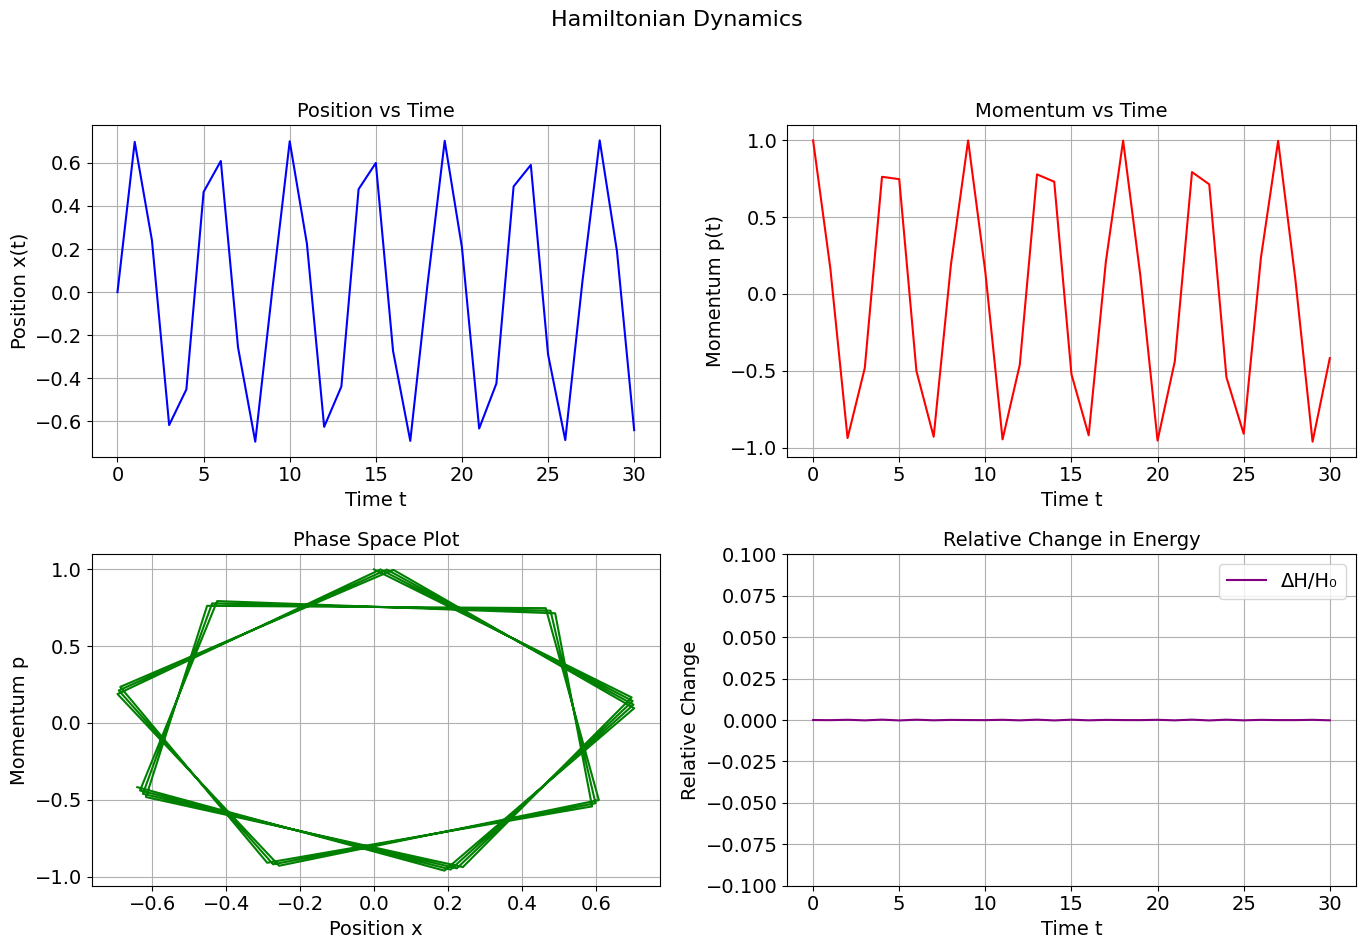

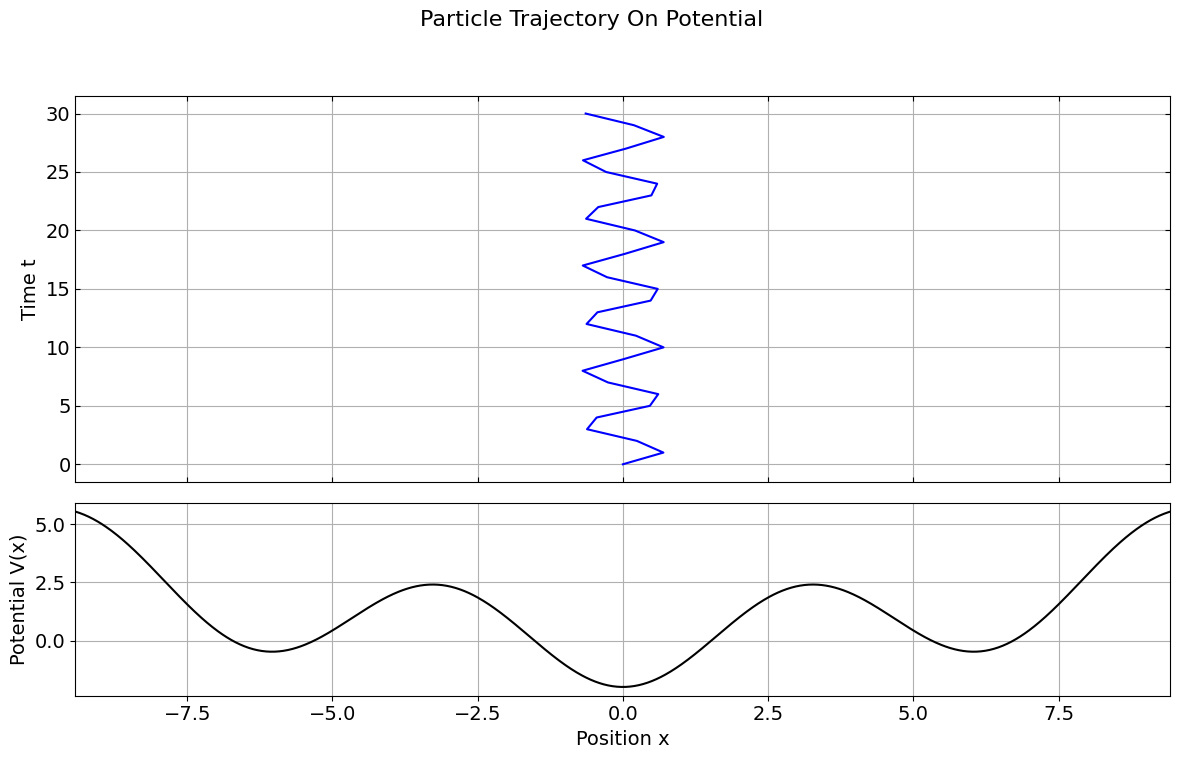

>>> Number of force calculation:  30000
>>> Maximum displacement:  0.6991319053400079


In [3]:
# Define the parameters
delta_t = 0.001  # Time step
N_force = 0  # Number of force calculation

# Fixed initial condition
x0, p0 = 0.0, 1.0

# Create Hamiltonian system
hamilton_system = HamiltonSystem(H1_p_dot, H1_x_dot, t_max, delta_t)

# Simulate for the fixed initial condition
t_array, x_array, p_array = hamilton_system.simulate(x0, p0)
N_force += len(t_array) - 1 # each time of simulate includes a dV / dx calculation

# Pick the data at each second
t_sampled, x_sampled, p_sampled = hamilton_system.pick_data(t_array, x_array, p_array)

# Calculate energy
energy_sampled = H1_H(x_sampled, p_sampled)

# Plotting
plotter = Plotter()
plotter.static_plots("Hamiltonian", t_sampled, x_sampled, p_sampled, energy_sampled)
plotter.trajectory_plot(x_sampled, t_sampled, potential)

print(">>> Number of force calculation: ", N_force)
print(">>> Maximum displacement: ", (np.max(x_sampled) - np.min(x_sampled)) / 2)


### Single initial condition, Hamiltonian 2

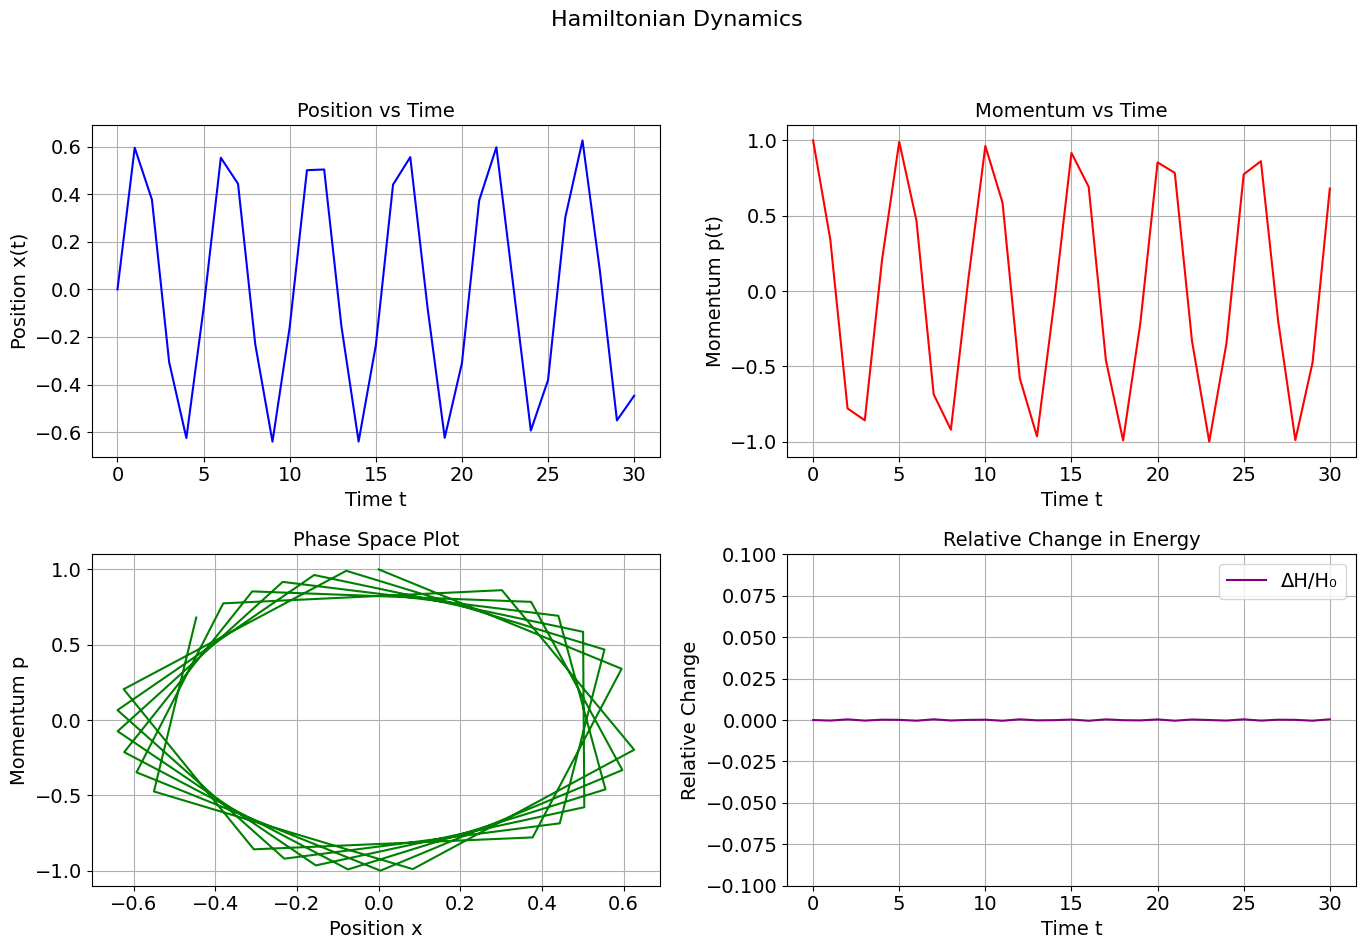

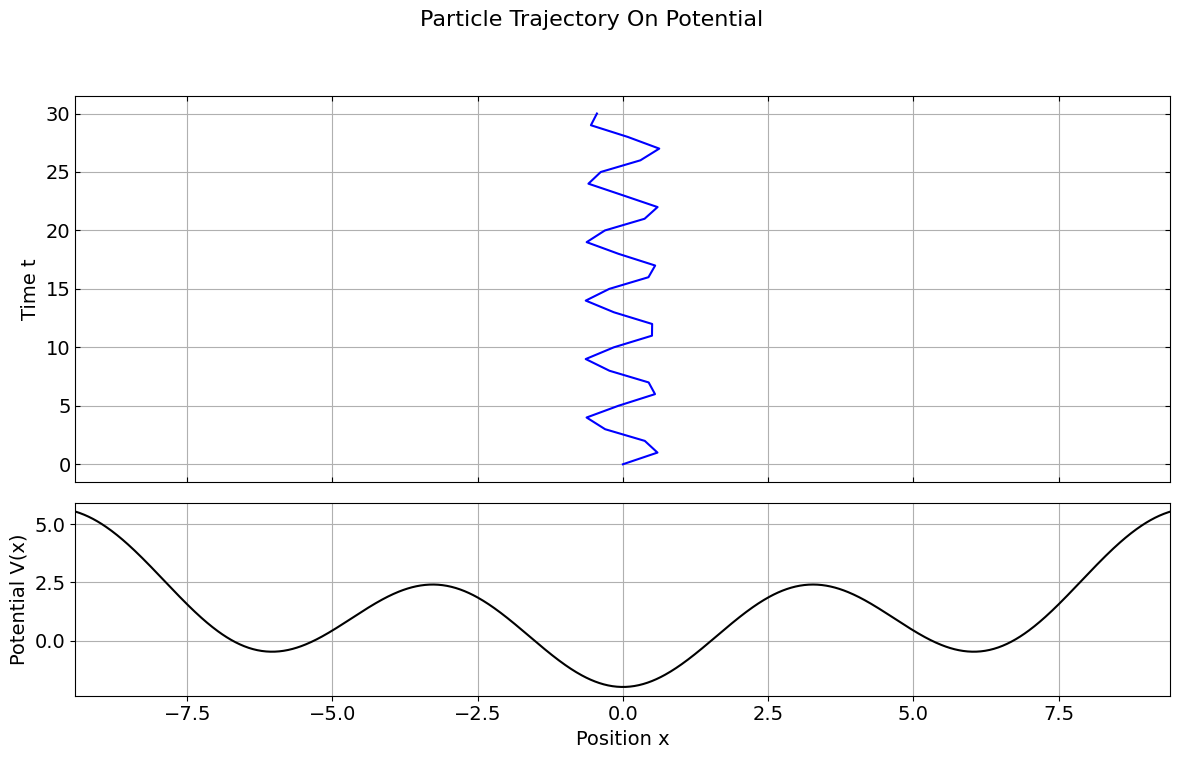

>>> Number of force calculation:  30000
>>> Maximum displacement:  0.6328808402364445


In [4]:
# Define the parameters
delta_t = 0.001  # Time step
N_force = 0  # Number of force calculation

# Fixed initial condition
x0, p0 = 0.0, 1.0

# Create Hamiltonian system
hamilton_system = HamiltonSystem(H2_p_dot, H2_x_dot, t_max, delta_t)

# Simulate for the fixed initial condition
t_array, x_array, p_array = hamilton_system.simulate(x0, p0)
N_force += len(t_array) - 1 # each time of simulate includes a dV / dx calculation

# Pick the data at each second
t_sampled, x_sampled, p_sampled = hamilton_system.pick_data(t_array, x_array, p_array)

# Calculate energy
energy_sampled = H2_H(x_sampled, p_sampled)

# Plotting
plotter = Plotter()
plotter.static_plots("Hamiltonian", t_sampled, x_sampled, p_sampled, energy_sampled)
plotter.trajectory_plot(x_sampled, t_sampled, potential)

print(">>> Number of force calculation: ", N_force)
print(">>> Maximum displacement: ", (np.max(x_sampled) - np.min(x_sampled)) / 2)

### Sampling


>>> Generated 5000 sets of (p0) satisfies p(p0) ∝ exp(-H(p0))


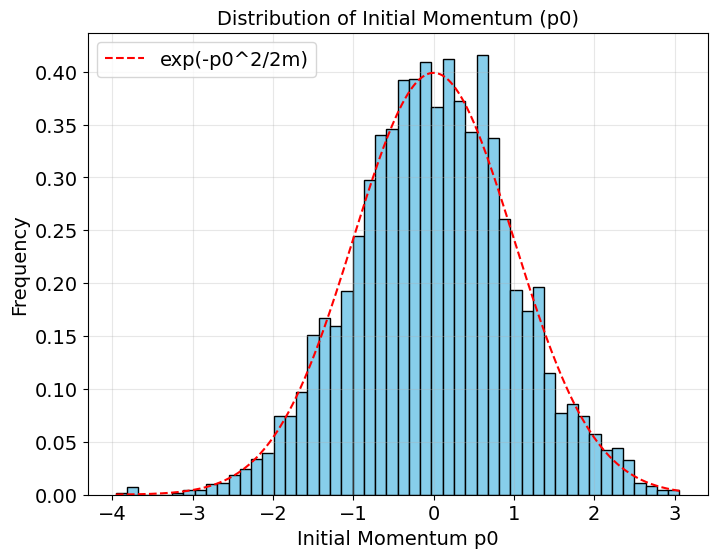

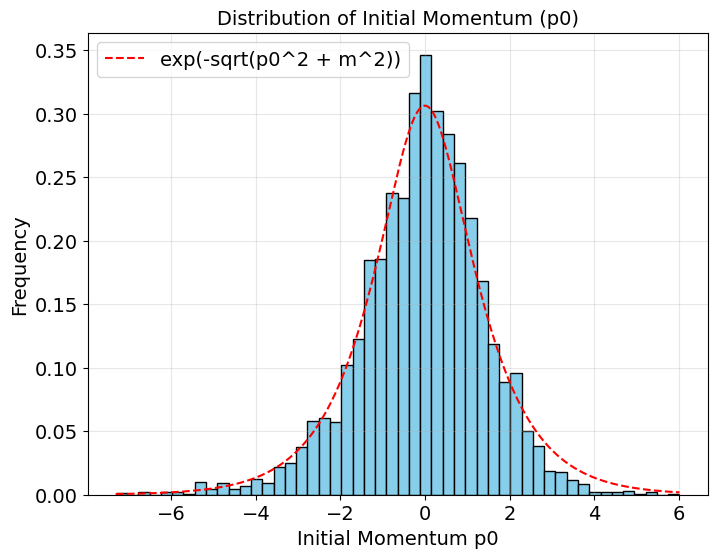

In [5]:
Nsamp = 5000
H1_p_term = lambda p: p**2 / (2 * m)
H2_p_term = lambda p: np.sqrt(p**2 + m**2)

H1_p0_samples = sample_initial_conditions(Nsamp, H1_p_term, r_term=None)
H2_p0_samples = sample_initial_conditions(Nsamp, H2_p_term, r_term=None)
print(f"\n>>> Generated {Nsamp} sets of (p0) satisfies p(p0) ∝ exp(-H(p0))")

# Create a histogram of H1_p0_samples
plt.figure(figsize=(8, 6))
plt.hist(H1_p0_samples, bins=50, color='skyblue', edgecolor='black', density=True)
# Add theoretical distribution line
x_range = np.linspace(min(H1_p0_samples), max(H1_p0_samples), 1000)
theoretical_dist = np.exp(-x_range**2 / 2 / m) / np.sqrt(2 * np.pi)  # Normalized Gaussian distribution
plt.plot(x_range, theoretical_dist, color='red', linestyle='--', label='exp(-p0^2/2m)')
plt.title("Distribution of Initial Momentum (p0)")
plt.xlabel("Initial Momentum p0")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Create a histogram of H2_p0_samples
plt.figure(figsize=(8, 6))
plt.hist(H2_p0_samples, bins=50, color='skyblue', edgecolor='black', density=True)
# Add theoretical distribution line
x_range = np.linspace(min(H2_p0_samples), max(H2_p0_samples), 1000)
theoretical_dist = np.exp(-np.sqrt(x_range**2 + m**2)) 
normalization = np.trapz(np.exp(-np.sqrt(x_range**2 + m**2)), x_range)
theoretical_dist /= normalization
plt.plot(x_range, theoretical_dist, color='red', linestyle='--', label='exp(-sqrt(p0^2 + m^2))')
plt.title("Distribution of Initial Momentum (p0)")
plt.xlabel("Initial Momentum p0")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Calculate the Pcross(n; x0)

In [6]:
x_search = np.linspace(-50, 50, 10000)
potential_values = potential(x_search) # * think about use which potential
local_maxima_indices = (
    np.where(
        (potential_values[1:-1] > potential_values[:-2])
        & (potential_values[1:-1] > potential_values[2:])
    )[0]
    + 1
)
local_maxima = x_search[local_maxima_indices]
print(f"\n>>> Local maxima of the potential function at:", local_maxima)


>>> Local maxima of the potential function at: [-23.17731773 -16.42664266  -9.8259826   -3.27532753   3.27532753
   9.8259826   16.42664266  23.17731773]


### Calculate the Pmax(x; x0)

>>> Using Hamiltonian 1: 


Loop in samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Loop in samples: 100%|██████████| 5000/5000 [09:17<00:00,  8.97it/s]


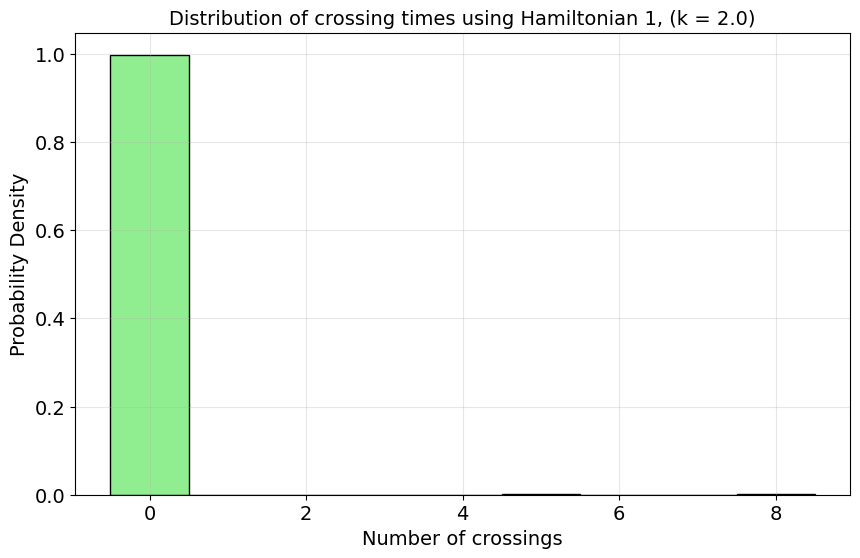

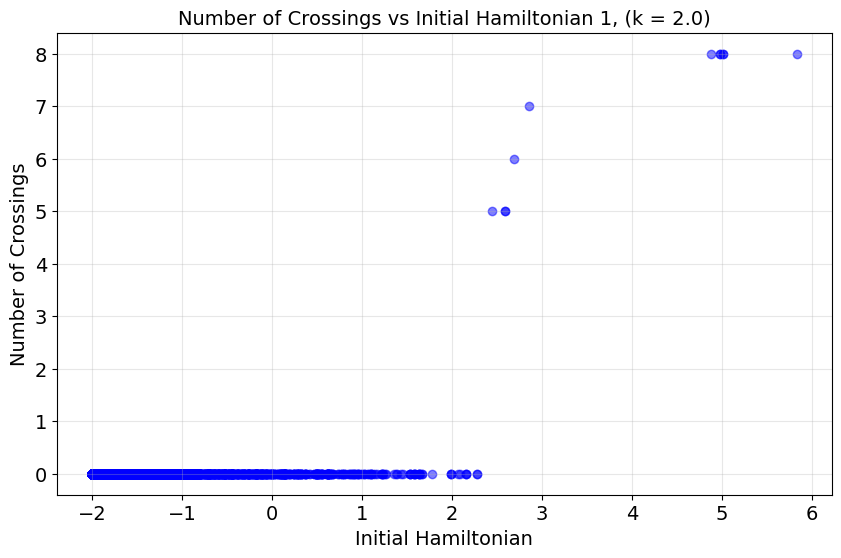

Average number of crossings: 0.0152


In [7]:
print(">>> Using Hamiltonian 1: ")

# Define the parameters
delta_t = 0.001  # Time step

# Initial conditions
x0 = 0.0

hamilton_system = HamiltonSystem(H1_p_dot, H1_x_dot, t_max, delta_t)

times_of_crossing = []
for p0 in tqdm(H1_p0_samples, desc="Loop in samples"):
    t_array, x_array, p_array = hamilton_system.simulate(x0, p0)

    # Count how many times the particle crosses the local maxima
    crossings = 0
    for i in range(1, len(x_array)):
        for max_x in local_maxima:
            if (x_array[i-1] - max_x) * (x_array[i] - max_x) < 0:
                crossings += 1
    times_of_crossing.append(crossings)

# Create histogram of displacements
plt.figure(figsize=(10, 6))
bins = np.arange(min(times_of_crossing), max(times_of_crossing) + 2) - 0.5
plt.hist(times_of_crossing, bins=bins, color='lightgreen', edgecolor='black', density=True)
plt.title(f"Distribution of crossing times using Hamiltonian 1, (k = {k})")
plt.xlabel("Number of crossings")
plt.ylabel("Probability Density")
plt.grid(True, alpha=0.3)
plt.show()


# Calculate initial Hamiltonian values
initial_H = [H1_H(x0, p0) for p0 in H1_p0_samples]

# Create scatter plot of times_of_crossing vs initial H
plt.figure(figsize=(10, 6))
plt.scatter(initial_H, times_of_crossing, alpha=0.5, color='blue')
plt.title(f"Number of Crossings vs Initial Hamiltonian 1, (k = {k})")
plt.xlabel("Initial Hamiltonian")
plt.ylabel("Number of Crossings")
plt.grid(True, alpha=0.3)
plt.show()


# Calculate and print the average number of crossings
avg_max_displacement = np.mean(times_of_crossing)
print(f"Average number of crossings: {avg_max_displacement:.4f}")


>>> Using Hamiltonian 2: 


Loop in samples: 100%|██████████| 5000/5000 [10:56<00:00,  7.62it/s]


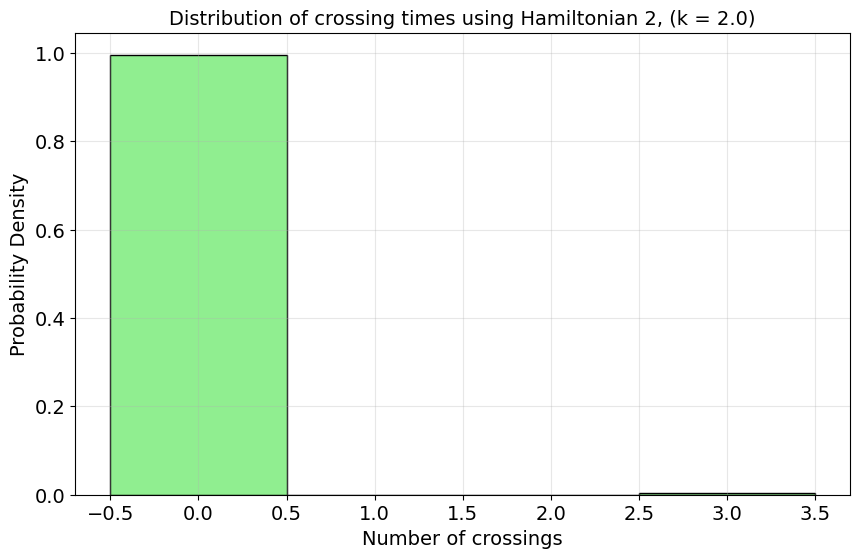

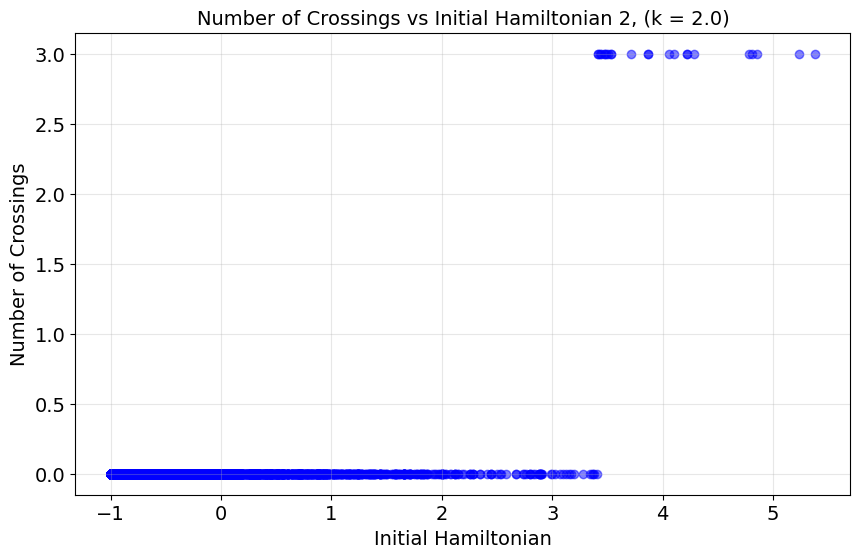

Average number of crossings: 0.0138


In [8]:
print(">>> Using Hamiltonian 2: ")

# Define the parameters
delta_t = 0.001  # Time step

# Initial conditions
x0 = 0.0

hamilton_system = HamiltonSystem(H2_p_dot, H2_x_dot, t_max, delta_t)

times_of_crossing = []
for p0 in tqdm(H2_p0_samples, desc="Loop in samples"):
    t_array, x_array, p_array = hamilton_system.simulate(x0, p0)

    # Count how many times the particle crosses the local maxima
    crossings = 0
    for i in range(1, len(x_array)):
        for max_x in local_maxima:
            if (x_array[i-1] - max_x) * (x_array[i] - max_x) < 0:
                crossings += 1
    times_of_crossing.append(crossings)

# Create histogram of displacements
plt.figure(figsize=(10, 6))
bins = np.arange(min(times_of_crossing), max(times_of_crossing) + 2) - 0.5
plt.hist(times_of_crossing, bins=bins, color='lightgreen', edgecolor='black', density=True)
plt.title(f"Distribution of crossing times using Hamiltonian 2, (k = {k})")
plt.xlabel("Number of crossings")
plt.ylabel("Probability Density")
plt.grid(True, alpha=0.3)
plt.show()


# Calculate initial Hamiltonian values
initial_H = [H2_H(x0, p0) for p0 in H2_p0_samples]

# Create scatter plot of times_of_crossing vs initial H
plt.figure(figsize=(10, 6))
plt.scatter(initial_H, times_of_crossing, alpha=0.5, color='blue')
plt.title(f"Number of Crossings vs Initial Hamiltonian 2, (k = {k})")
plt.xlabel("Initial Hamiltonian")
plt.ylabel("Number of Crossings")
plt.grid(True, alpha=0.3)
plt.show()


# Calculate and print the average number of crossings
avg_max_displacement = np.mean(times_of_crossing)
print(f"Average number of crossings: {avg_max_displacement:.4f}")


### Test